In [1]:
import nestpy
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:

#create detector
detector = nestpy.DetectorExample_LUX_RUN03()

z_max = detector.get_TopDrift()
r_max = detector.get_radius() # fid radius??
dt_min = detector.get_dt_min() # analysis min dt
dt_max = detector.get_dt_max() # analysis max dt
print(z_max, r_max, dt_min, dt_max)

544.95 200.0 80.0 130.0


In [ ]:
# run a single recoil
keV=10
type_num = nestpy.INTERACTION_TYPE(0) # NR
pos_x, pos_y, pos_z = 0., 0., z_max/2.
inField=180

obs = nestpy.runNEST(detector, keV, type_num, inField, pos_x, pos_y, pos_z, seed=0)

s1c_phd = obs.s1c_phd
s2c_phd = obs.s2c_phd
print(s1c_phd, s2c_phd)

In [3]:
# run many recoils with vectorized arguments


n_events=100
keV=np.linspace(0, 100, n_events)
type_num = nestpy.INTERACTION_TYPE(0) # NR

r = np.random.uniform(low=0, high=r_max, size=n_events)
phi = np.random.uniform(low=0, high=2*np.pi, size=n_events)
pos_x = r * np.cos(phi);
pos_y = r * np.sin(phi);
pos_z = np.random.uniform(low=0, high=z_max, size=n_events)


inField=180
obs_arr = nestpy.runNEST_vec(detector, keV.tolist(), type_num, inField, pos_x.tolist(), pos_y.tolist(), pos_z.tolist(), 0)
s1 = obs_arr.s1c_phd
s2 = obs_arr.s2c_phd


/Users/xinxiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


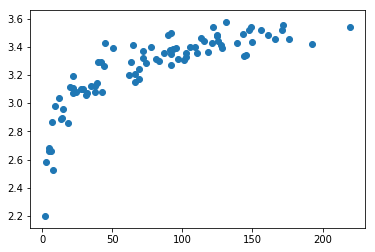

In [4]:
plt.scatter(s1, np.log10(s2))
plt.show()